## Lesson 10 rough notes

Based on lecture slides.

### Potential decisions d - or actions a

- Potential consequences x
    - x may be categorical, ordinal, real, scalar, vector, etc.
- Probability distributions of consequences given decisions p(x | d)

- in decision making the decisions are controlled and thus p(d) does not exist
- Utility function U(x) maps consequences to real value - e.g. euro or expected lifetime
    - instead of utility sometimes cost or loss is defined
- Expected utility E[U(x) | d] = ∫ U(x)p(x | d)dx
- Choose decision d∗, which maximizes the expected utility:

$$
d∗ = arg \max_d E[U(x) | d]
$$

### Challenges:

- Actual utility functions are generally non-linear (e.g. log utility for money)
- Utility functions are often unknown (What is the cost of a life?)
- Utility is not comparable between people

Example in lecture is interesting, choosing between treatments and even diagnostic methods for 95 year old patient!

### Bayesian optimization 

- Decision on what measurement to make next.
- Used in many places: 
    - Hyperparameter optimization for machine learning
    - Experimental design
    - material science
    - engines
    - drug testing
    - part of Bayesian inference for stochastic simulators

- Lecture uses Gaussian processes to model unknown function f(x) to be optimized (flight time as a function of wing length for paper airplanes)

Basic idea:
- Start with a few measurements
- Fit a GP to the measurements (surrogate model). Bayesian so it has also predictive uncertainty
- Use an acqusition function to decide where to measure next
    - Balance exploration and exploitation
    - Examples: Expected improvement, probability of improvement, upper confidence bound
- Lecture uses 'Thompson sampling' - sample a function from the GP posterior and optimize it, sample at that optimum and repeat.


## Laplace approximation

* $n \rightarrow \infty$ - posterior approaches a Gaussian when:
    * parameters don't grow with n
    * Posterior is bounded, non-singlular.
    * Prior is smooth and non-zero at the true parameter value
    * Likelihood is smooth and has a unique maximum at the true parameter value

* Taylor expansion of log posterior around the mode $\theta^*$:
$$
\log p(\theta | D) \approx \log p(\theta^* | D) - \frac{1}{2} (\theta - \theta^*)^T H (\theta - \theta^*)
$$
where H is the Hessian of the negative log posterior at the mode. Also called observed information matrix $I$. 
* THis can be computed numerically using autodiff or finite differences.  
* cmdstanR has this built in (as far as I know it is not so easy in PYMC) 
    * Transforms parameters to unconstrained space first (Keeping track of Jacobian is important!)
    * uses L-BFGS to find the mode, autodiff for gradients, finite differences for Hessian(I think)
   
* This is typically much faster than MCMC sampling and can be sufficient for many tasks.
    * Gaussian latent variable models (e.g. GP) is one example, see Rasmussen and Williams book.
* Accuracy can be improved using importance sampling. (I think stan has this option?).
    * If PSIS is used, the Pareto k diagnostic can be used as a diagnostic too.


### Chapter 4 demo 4.1

Bioassay experment (BDA3 page 74).  Recall this was tests of different doses(x) of a drug on n=5 animals each, recording the number of animals that died (y)

In [2]:
import numpy as np
from scipy import optimize, stats
import matplotlib.pyplot as plt

# Bioassay data, (BDA3 page 86)
x = np.array([-0.86, -0.30, -0.05, 0.73])
n = np.array([5, 5, 5, 5])
y = np.array([0, 1, 3, 5])

The model is a logistic regression with parameters alpha (A) and beta (B), where the probability of death is modeled as:

$$
p(x) = \frac{1}{1 + e^{-(\alpha + \beta x)}}
$$


Compute posterior for bioassy using grid appproximation, assuming improper flat prior on (A,B).

 

In [8]:
ngrid = 100
A = np.linspace(-4, 8, ngrid)
B = np.linspace(-10, 40, ngrid)
ilogit_abx = 1 / (np.exp(-(A[:,None] + B[:,None,None] * x)) + 1)
p = np.prod(ilogit_abx**y * (1 - ilogit_abx)**(n - y), axis=2)

# sample from the grid
nsamp = 1000
samp_indices = np.unravel_index(
    np.random.choice(p.size, size=nsamp, p=p.ravel()/np.sum(p)),
    p.shape
)
samp_A = A[samp_indices[1]]
samp_B = B[samp_indices[0]]
# add random jitter, see BDA3 p. 76
samp_A += (np.random.rand(nsamp) - 0.5) * (A[1]-A[0])
samp_B += (np.random.rand(nsamp) - 0.5) * (B[1]-B[0])

# samples of LD50
samp_ld50 = - samp_A / samp_B

Instead of grid approximation, we can use Laplace approximation to get a Gaussian approximation to the posterior. Find the mode by minimising negative log posterior. Compute gradients and Hessian analytically, and use Newton's method for optimisation.

In [4]:
def bioassayfun(w):
    a = w[0]
    b = w[1]
    et = np.exp(a + b * x)
    z = et / (1 + et)
    e = - np.sum(y * np.log(z) + (n - y) * np.log(1 - z))
    return e
# initial guess
w0 = np.array([0.0, 0.0])
# optimise
optim_res = optimize.minimize(bioassayfun, w0)
# extract desired results
w = optim_res['x']
S = optim_res['hess_inv']

Sample from the Gaussian approximation and compare to grid approximation.
Demo 4.1 says to see NP documentation for how the stride tricks work. (I wonder why this is needed?)

In [6]:
A_broadcasted = np.lib.stride_tricks.as_strided(
    A, shape=(ngrid,ngrid), strides=(0, A.strides[0]))
B_broadcasted = np.lib.stride_tricks.as_strided(
    B, shape=(ngrid,ngrid), strides=(B.strides[0], 0))
grid = np.dstack((A_broadcasted, B_broadcasted))
p_norm = stats.multivariate_normal.pdf(x=grid, mean=w, cov=S)

# draw samples from the distribution
samp_norm = stats.multivariate_normal.rvs(mean=w, cov=S, size=1000)

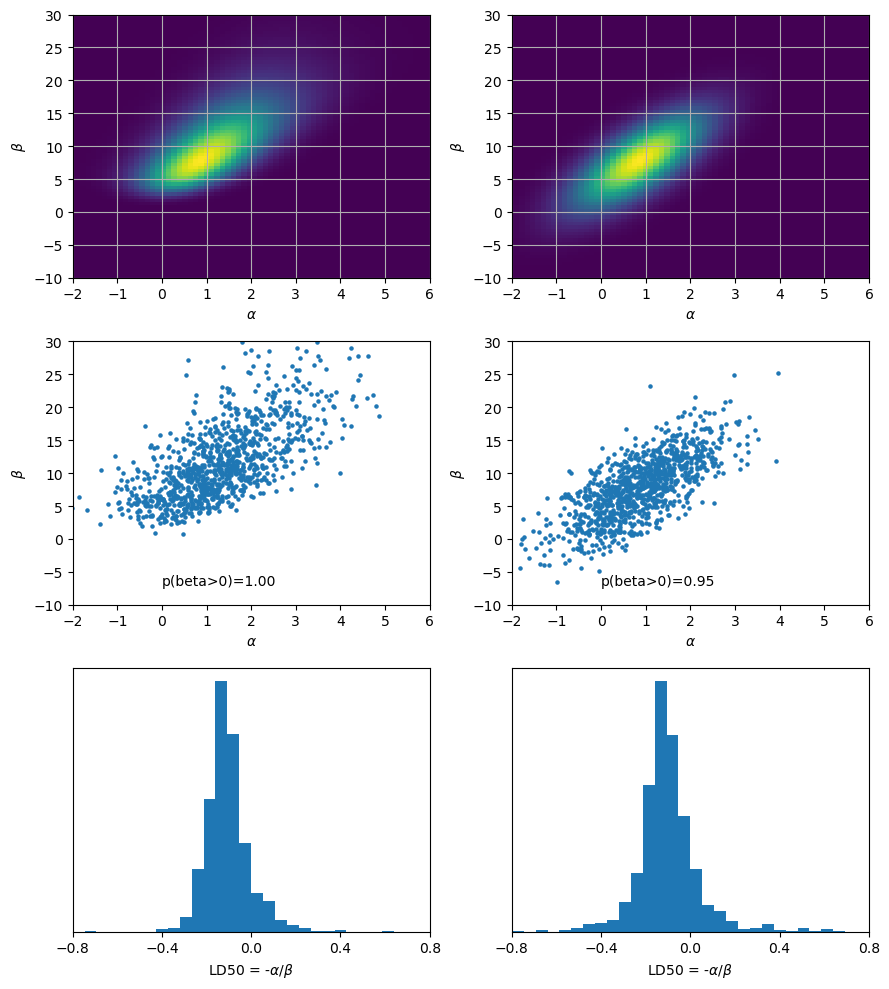

In [9]:
# create figure
fig, axes = plt.subplots(3, 2, figsize=(9, 10))

# plot the posterior density
ax = axes[0, 0]
ax.imshow(
    p,
    origin='lower',
    aspect='auto',
    extent=(A[0], A[-1], B[0], B[-1])
)
ax.set_xlim([-2, 6])
ax.set_ylim([-10, 30])
ax.set_xlabel(r'$\alpha$')
ax.set_ylabel(r'$\beta$')
ax.grid('off')

# plot the samples
ax = axes[1, 0]
ax.scatter(samp_A, samp_B, 5)
ax.set_xlim([-2, 6])
ax.set_ylim([-10, 30])
ax.set_xlabel(r'$\alpha$')
ax.set_ylabel(r'$\beta$')
ax.text(0, -7, 'p(beta>0)={:.2f}'.format(np.mean(samp_B>0)))

# plot the histogram of LD50
ax = axes[2, 0]
ax.hist(samp_ld50, np.linspace(-0.8, 0.8, 31))
ax.set_xlim([-0.8, 0.8])
ax.set_xlabel(r'LD50 = -$\alpha/\beta$')
ax.set_yticks(())
ax.set_xticks(np.linspace(-0.8, 0.8, 5))

# plot the posterior density for normal approx.
ax = axes[0, 1]
ax.imshow(
    p_norm,
    origin='lower',
    aspect='auto',
    extent=(A[0], A[-1], B[0], B[-1])
)
ax.set_xlim([-2, 6])
ax.set_ylim([-10, 30])
ax.set_xlabel(r'$\alpha$')
ax.set_ylabel(r'$\beta$')
ax.grid('off')

# plot the samples from the normal approx.
ax = axes[1, 1]
ax.scatter(samp_norm[:,0], samp_norm[:,1], 5)
ax.set_xlim([-2, 6])
ax.set_ylim([-10, 30])
ax.set_xlabel(r'$\alpha$')
ax.set_ylabel(r'$\beta$')

# Normal approximation does not take into account that the posterior
# is not symmetric and that there is very low density for negative
# beta values. Based on the samples from the normal approximation
# it is estimated that there is about 4% probability that beta is negative!
ax.text(0, -7, 'p(beta>0)={:.2f}'.format(np.mean(samp_norm[:,1]>0)))

# Plot the histogram of LD50
ax = axes[2, 1]
# Since we have strong prior belief that beta should not be negative we can
# improve our normal approximation by conditioning on beta>0.
bpi = samp_norm[:,1] > 0
samp_ld50_norm = - samp_norm[bpi,0] / samp_norm[bpi,1]
ax.hist(samp_ld50_norm, np.linspace(-0.8, 0.8, 31))
ax.set_xlim([-0.8, 0.8])
ax.set_xlabel(r'LD50 = -$\alpha/\beta$')
ax.set_yticks(())
ax.set_xticks(np.linspace(-0.8, 0.8, 5))

fig.tight_layout()


### Other distributional approximations

- Higher order derivatives at the mode can be used
 
- Variational inference (Ch 13)
    - Stan has the ADVI algorithm (not very good implementation)
    - Pathfinder algorithm (CmdStanR, brms) (see [paper](https://jmlr.org/papers/v23/21-0889.html), also note PYMC implementation)


- instead of normal, methods with flexible flow transformations (e.g. normalizing flows) can be used
- expectation propagation (Ch 13)

- speed of these is usually between optimization and MCMC
    - stochastic variational inference can be even slower than MCMC


### BRMS suppport:

- brms supports Laplace / Pathfinder / ADVI
- These might be useful for initializng MCMC or big data. The ADVI implementation is not very good.
```
fit1 <- brm(..., algorithm = "laplace")
fit1 <- brm(..., algorithm = "pathfinder")
fit1 <- brm(..., algorithm = "meanfield")
fit1 <- brm(..., algorithm = "fullrank")
```